# Soft K-means example

In [1]:
library(tidyverse)
Sys.setenv(RETICULATE_PYTHON = "/nix/store/66p7i56lg3zzp7nj6g0fywb704ihp4iy-python3-3.8.11/bin/python")
library(reticulate)
pd = import("pandas")
`%+%` = paste0

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Introduction

## Data generation

In [2]:
# Generate data points
dg = import("make_data")
n_points1 = 80
n_points2 = 120
mu1 = 0
mu2 = 1.5
n_total = n_points1 + n_points2
data_points = dg$generate_data(
    means = list(list(mu1), list(mu2)), # 1D
#     means = list(list(0,3), list(4,0)), # 2D
    n_points = c(as.integer(n_points1), as.integer(n_points2))
)

In [3]:
# Prepare data
data_points %>%
as.matrix() %>%
{colnames(.) = c("x"); .} %>%
as_tibble() %>%
mutate(cluster_id = c(rep(1, n_points1), rep(2, n_points2))) -> data_points_

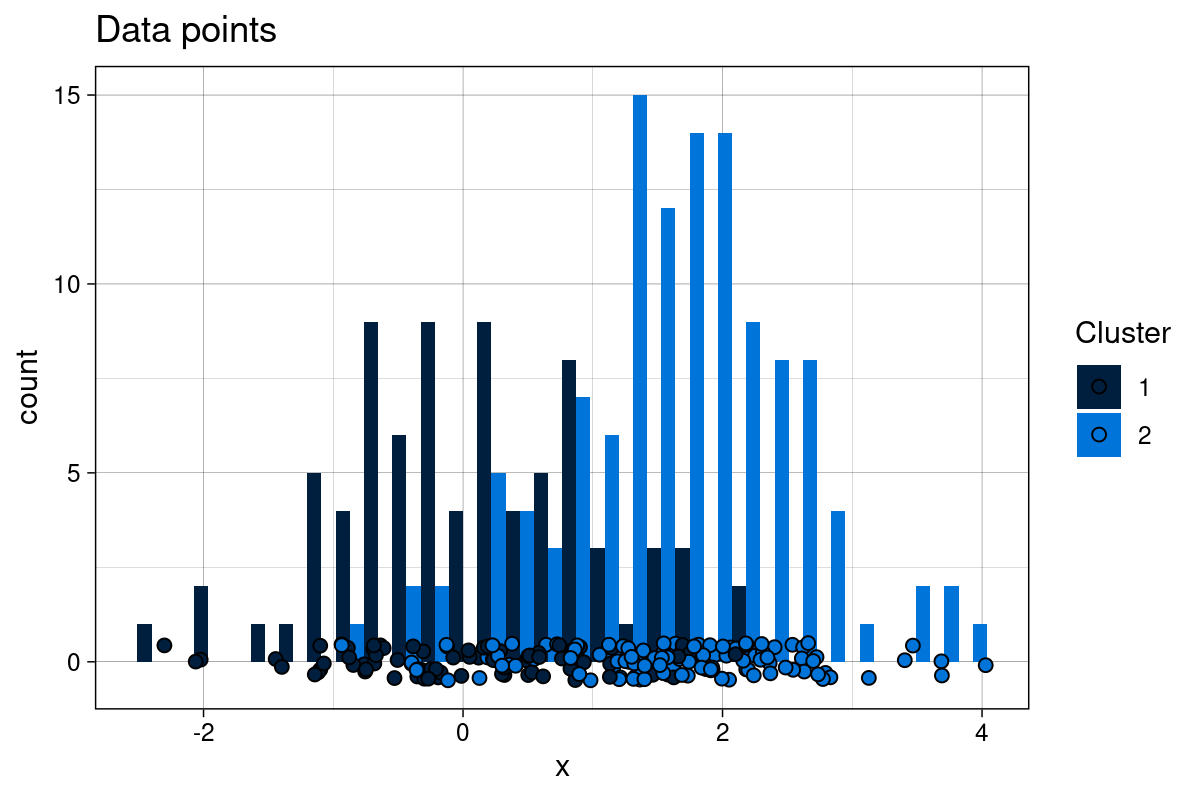

In [4]:
# Plot data points (1D version)
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
ggplot(data_points_ %>% sample_n(nrow(.))) +
geom_histogram(aes(x, fill=as.character(cluster_id)), bins=30, position="dodge") +
geom_jitter(
    aes(x, 0, fill=as.character(cluster_id)), height=0.5, size=2, shape=21,
) +
labs(
    title = "Data points",
    fill = "Cluster"
) + 
scale_x_continuous(breaks = seq(-100, 100, by=2)) +
scale_fill_manual(values=c("#001f3f", "#0074D9")) +
theme_linedraw()
# ggsave("images/data_points_1D.png", width=6, height=4)

## Model
The model is defined in the `probability.py` module.

In [5]:
# # Posterior distribution (1D & 2 clusters only) (R version)
# pb = import("probability")
# size = 100
# data_posterior = tibble(
#     x = list(seq(-1, 5, length.out=size)),
#     y = list(seq(-1, 5, length.out=size)),
# ) %>%
# unnest(x) %>%
# unnest(y) %>%
# mutate(prob = exp(map2_dbl(
#     x, y,
#     ~ pb$pdf$log_likelihood(matrix(c(.x, .y)))
# )))

# Posterior distribution (1D & 2 clusters only) (Python version - faster)
code = "
import numpy as np
from probability import pdf
import importlib
import sys
importlib.reload(sys.modules['probability'])
space = np.linspace(-1, 3, 200)
xs = [x for y in space for x in space]
ys = [y for y in space for x in space]
vals = [np.exp(pdf.log_prob(np.array([x, y]))) for y in space for x in space]
"
res = py_run_string(code)
data_posterior = tibble(
    mu1 = unlist(res["xs"]),
    mu2 = unlist(res["ys"]),
    prob = unlist(res["vals"])
)

Warning message:
“Removed 796 rows containing missing values (geom_raster).”


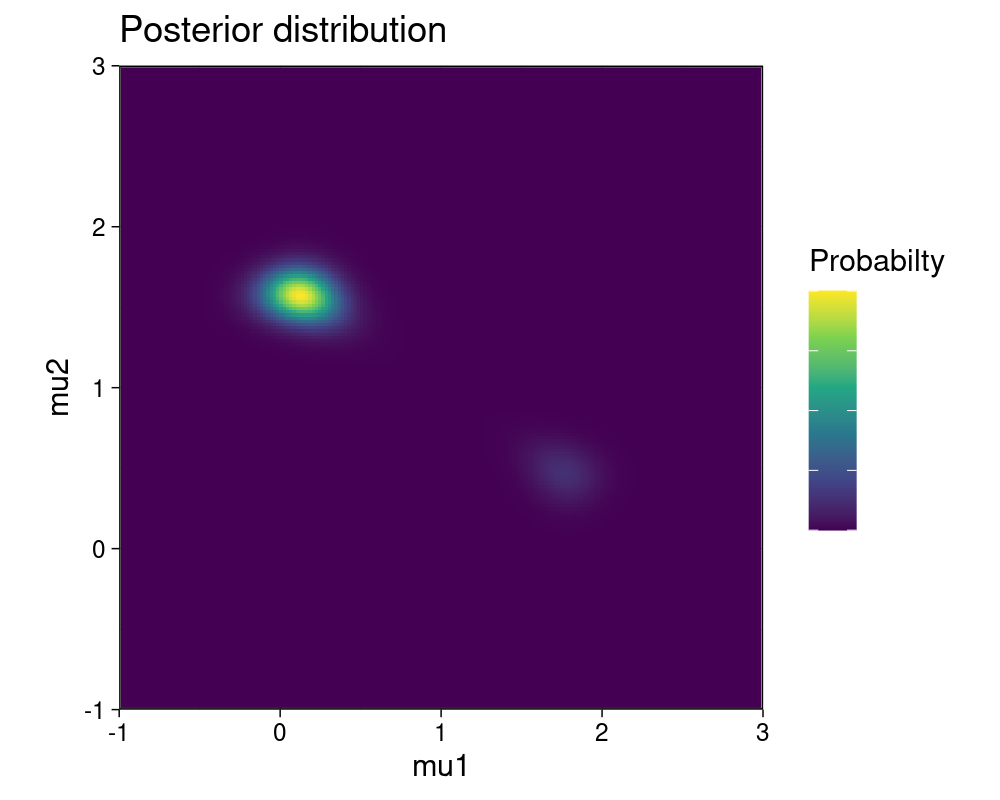

In [6]:
# Plot posterior
options(repr.plot.width=5, repr.plot.height=4, repr.plot.res=200)
ggplot(data_posterior) +
geom_raster(aes(mu1, mu2, fill=prob)) +
labs(
    title = "Posterior distribution",
    fill = "Probabilty"
) + 
scale_x_continuous(breaks = seq(-100, 100, by=1), expand=c(0,0), limits=c(-1, 3)) +
scale_y_continuous(breaks = seq(-100, 100, by=1), expand=c(0,0), limits=c(-1, 3)) +
scale_fill_viridis_c(option = "viridis", trans="identity", oob=scales::squish_infinite) +
coord_fixed() +
theme_linedraw() +
theme(legend.text=element_blank())
# ggsave("images/posterior_1D.png", width=5, height=4)

## Single chain

### Sampling

In [7]:
# Import probability density function (Python version - faster)
sc = import("single_chain")
importlib = import("importlib")
importlib$reload(sc)
n_samples = as.integer(2000)

# sampling
samples_sc = sc$sample_single_chain(n_samples, matrix(c(1, 0)))

# Prepare samples data
samples_sc %>%
{ colnames(.)=c("x", "y"); . } %>%
as_tibble() -> data_samples_sc

Module(single_chain)

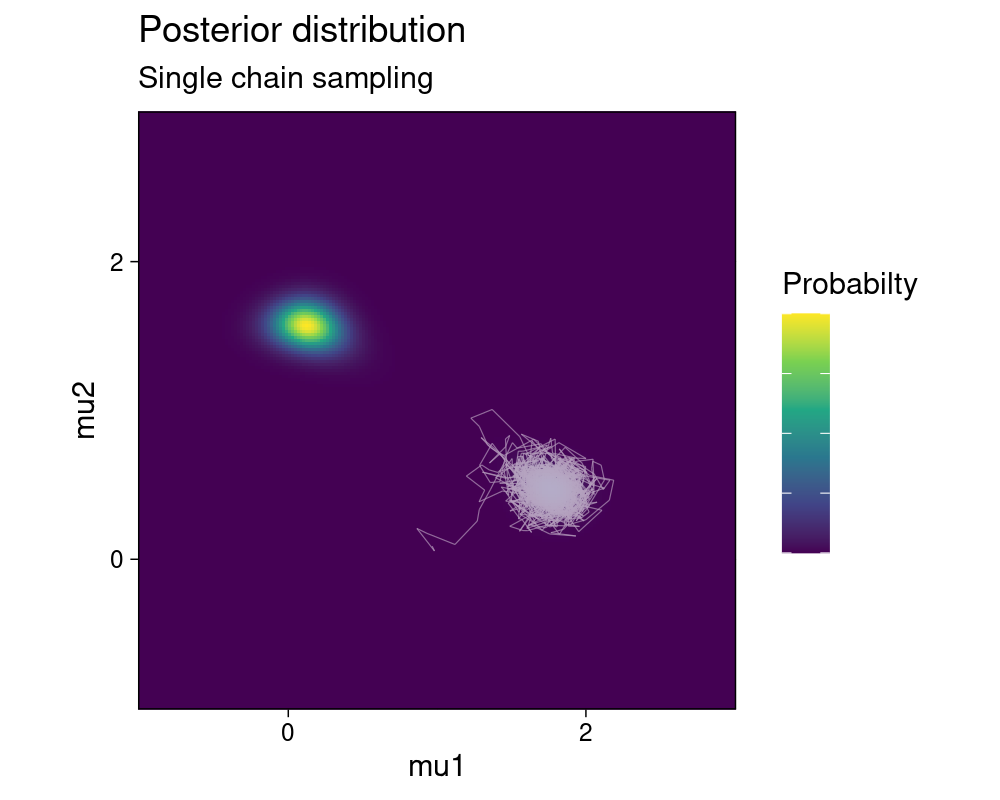

In [8]:
# Plot posterior
options(repr.plot.width=5, repr.plot.height=4, repr.plot.res=200)
ggplot(data_posterior) +
geom_raster(aes(mu1, mu2, fill=prob)) +
geom_segment(
    # Lot only the first X samples for clarity
    data = data_samples_sc %>% slice(1:2000),
    aes(x, y, xend=lead(x, default=last(x)), yend=lead(y, default=last(y))),
    color="white", size=0.2, alpha=0.7
) +
geom_raster(aes(mu1, mu2, fill=prob), alpha=0.4) +
labs(
    title = "Posterior distribution",
    subtitle = "Single chain sampling",
    fill = "Probabilty"
) + 
scale_x_continuous(breaks = seq(-100, 100, by=2), expand=c(0,0)) +
scale_y_continuous(breaks = seq(-100, 100, by=2), expand=c(0,0)) +
scale_fill_viridis_c(option = "viridis", trans="identity", oob = scales::squish_infinite) +
coord_fixed() +
theme_linedraw()+
theme(legend.text=element_blank())
# ggsave("images/sampling_sc_initstate-1-0.png", width=5, height=4)

### Means

In [9]:
# Compute transformed soft_z
data_samples_sc %>%
rename(mu1 = x, mu2 = y) %>%
gather() -> data_samples_sc_

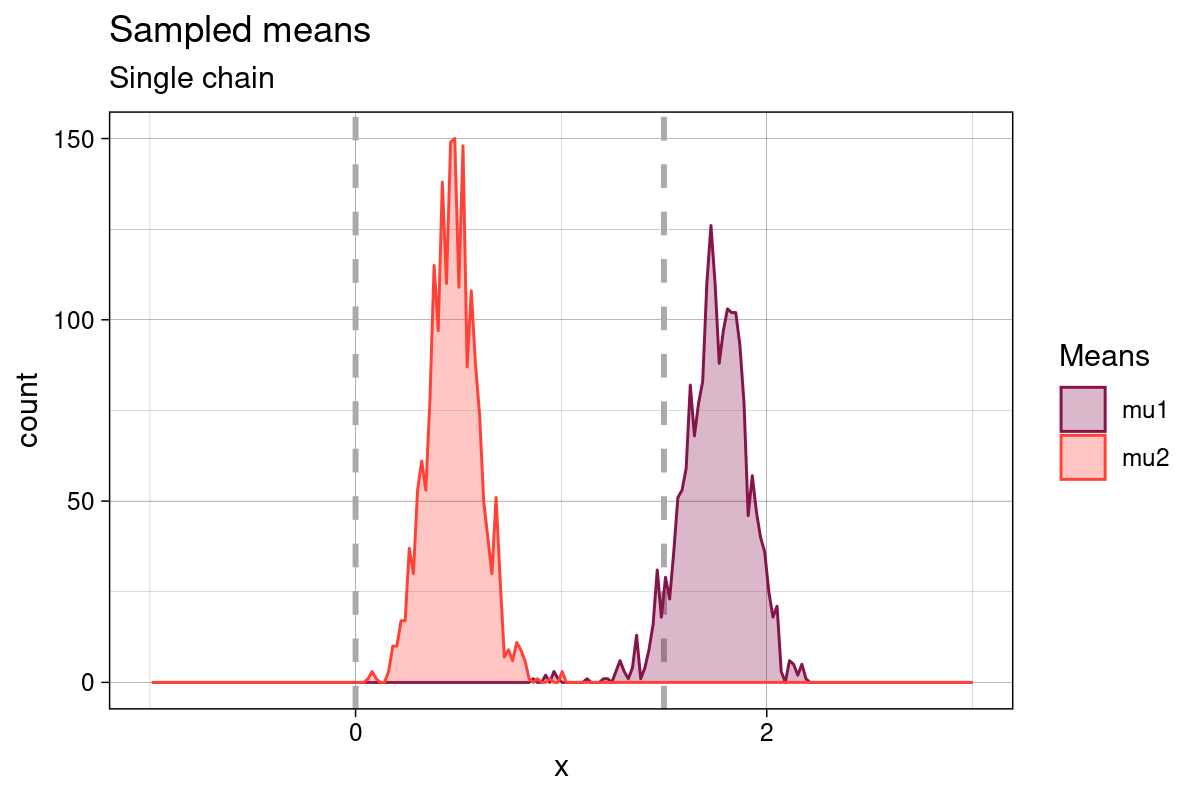

In [10]:
# Plot data points & samples
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
ggplot(data_samples_sc_) +
geom_vline(
    data=tibble(x=c(mu1, mu2)),
    aes(xintercept=x),
    size=1, color="#AAAAAA", linetype=2
) +
geom_area(
    aes(value, y=..count.., fill=key, color=key),
    stat="bin", bins=200, alpha=0.3, position="identity",
) +
scale_fill_manual(values=c("#85144b", "#FF4136")) +
scale_color_manual(values=c("#85144b", "#FF4136")) +
labs(
    title = "Sampled means",
    subtitle = "Single chain",
    fill = "Means",
    color = "Means",
    x = "x"
) + 
scale_x_continuous(breaks = seq(-100, 100, by=2), limits=c(-1, 3)) +
theme_linedraw()
# ggsave("images/samples_means_sc_initstate-1-0.png", width=6, height=4)

### Cluster assignment

In [11]:
# Compute soft_z
n_clusters = 2
weights = c(n_points1/n_total, n_points2/n_total)

data_samples_sc %>%
rename(mu1 = x, mu2 = y) %>%
mutate(sample_i = row_number()) %>%
gather(key=mu_i, value=mu, -sample_i) %>%
mutate(mu_i = case_when(mu_i=="mu1" ~ 1, mu_i=="mu2" ~ 2)) %>%
full_join(
    data_points_ %>% mutate(x_i=row_number()),
    by=character()
) %>%
mutate( soft_z = -log(n_clusters) -0.5 * (x - mu)**2 + log(weights[mu_i]) ) -> data_soft_z_sc

In [12]:
# Cluster assignment
## Softmax from https://gist.github.com/aufrank/83572
logsumexp <- function (x) {
  y = max(x)
  y + log(sum(exp(x - y)))
}
softmax <- function (x) {
  exp(x - logsumexp(x))
}
## cluster assignements
data_soft_z_sc %>%
group_by(mu_i, x_i) %>%
summarise(
    median_soft_z = median(soft_z),
    x = first(x),
    .groups='drop'
) %>%
group_by(x_i) %>%
mutate(prob_cluster = softmax(median_soft_z)) %>%
filter(prob_cluster == max(prob_cluster)) -> data_points_clusterized_sc

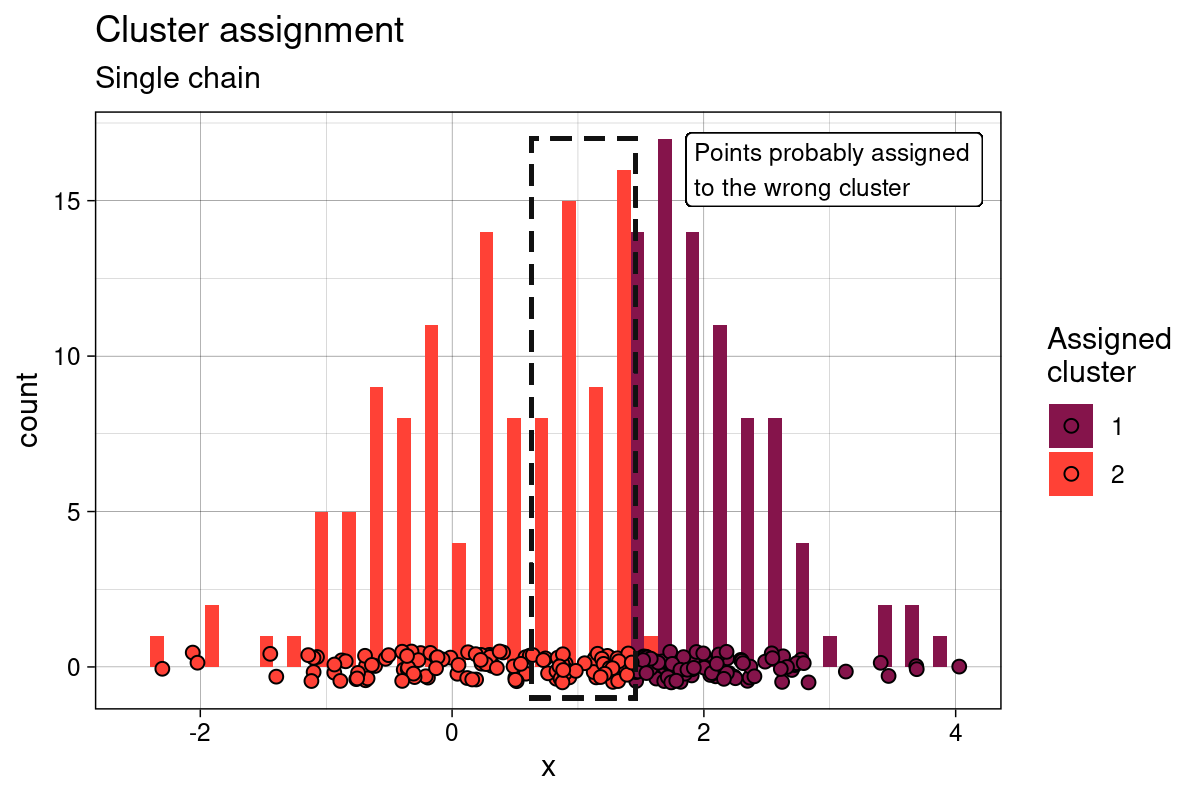

In [13]:
# Plot data points & samples
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
ggplot(data_points_clusterized_sc) +
geom_histogram(
    aes(x, fill=as.character(mu_i)), bins=30, alpha=1, position="dodge"
) +
geom_jitter(
    aes(x, 0, fill=as.character(mu_i)), height=0.5, size=2, shape=21
) +
geom_rect(
    xmin=0.63, xmax=1.46,
    ymin=-1, ymax=17,
    alpha=0, color="#111111", size=0.7, linetype=2
) +
geom_label(
    x=1.46+0.4, y=16, hjust=0,
    label = "Points probably assigned\nto the wrong cluster",
    size=3.1
) +
scale_x_continuous(breaks = seq(-100, 100, by=2)) +
scale_fill_manual(values=c("#85144b", "#FF4136")) +
labs(
    title = "Cluster assignment",
    subtitle = "Single chain",
    fill = "Assigned\ncluster"
) + 
theme_linedraw()
# ggsave("images/cluster_assignment_sc_initstate-1-0.png", width=6, height=4)

### Analysis of soft_z

In [14]:
# Select some points in particular
data_soft_z_sc %>%
group_by(sample_i, x_i) %>%
arrange(sample_i, x_i) %>%
mutate(soft_z = softmax(soft_z)) %>%
ungroup() %>%
nest( data = c(-x) ) %>%
arrange(x) %>%
slice(c(20, 117, 180)) %>%   # Points to select
unnest(data) %>%
mutate(
    x_label = "x = " %+% round(x, 3),
    mu_i = as.character(mu_i),
) -> data_soft_z_point_sc

# Compute medians
data_soft_z_point_sc %>%
group_by(x, mu_i, x_label) %>%
summarise(median_soft_z = median(soft_z), .groups='drop') %>%
mutate(median_legend = "") -> data_soft_z_point_median_sc

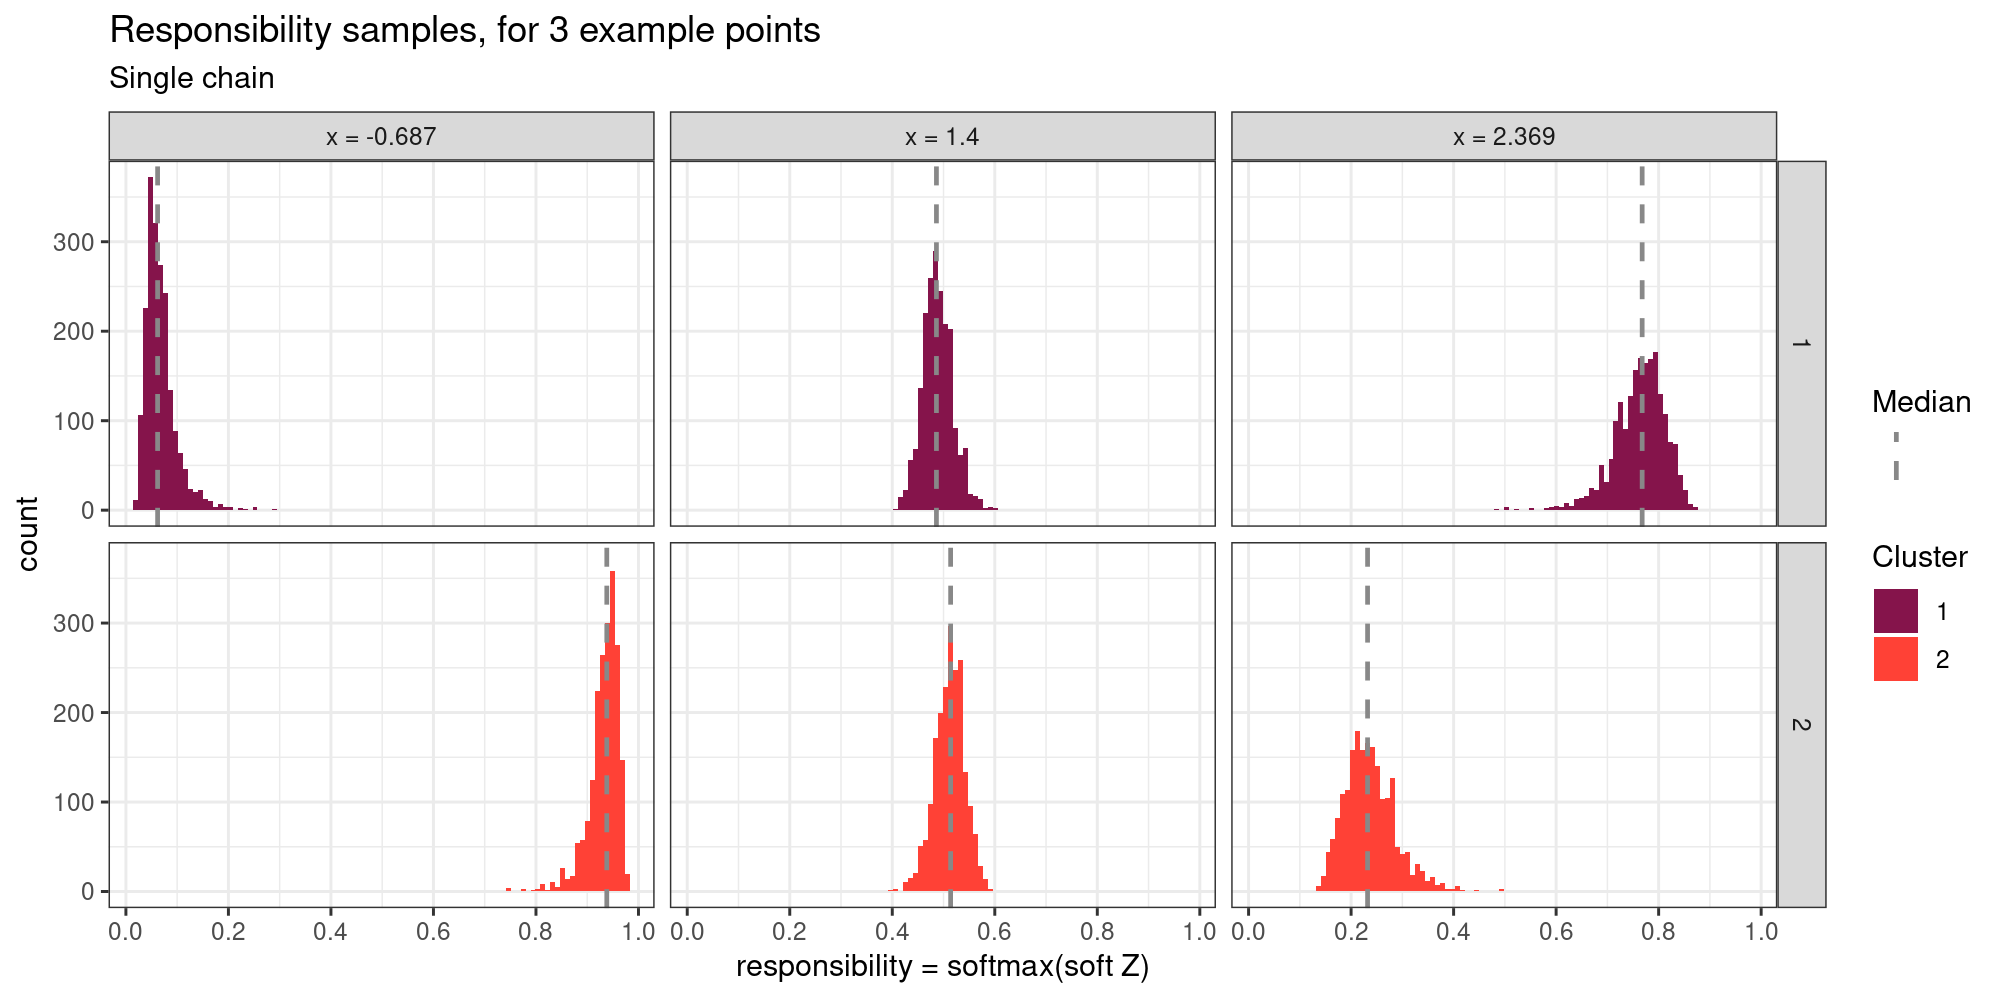

In [21]:
# Plot soft Z samples
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=200)
ggplot(data_soft_z_point_sc) +
geom_histogram(
    aes(soft_z, fill=mu_i),
    bins=100
) +
geom_vline(
    data = data_soft_z_point_median_sc,
    aes(xintercept=median_soft_z, color=median_legend),
    linetype=2, size=0.8
) +
scale_x_continuous(breaks = seq(-100, 100, by=0.2)) +
scale_color_manual(values=c("#888888")) +
scale_fill_manual(values=c("#85144b", "#FF4136")) +
facet_grid( cols=vars(x_label), rows= vars(mu_i) ) +
labs(
    title = "Responsibility samples, for 3 example points",
    subtitle = "Single chain",
    fill = "Cluster",
    x = "responsibility = softmax(soft Z)",
    color = "Median"
) + 
theme_bw()
# ggsave("images/soft-z_samples_sc.png", width=10, height=5)

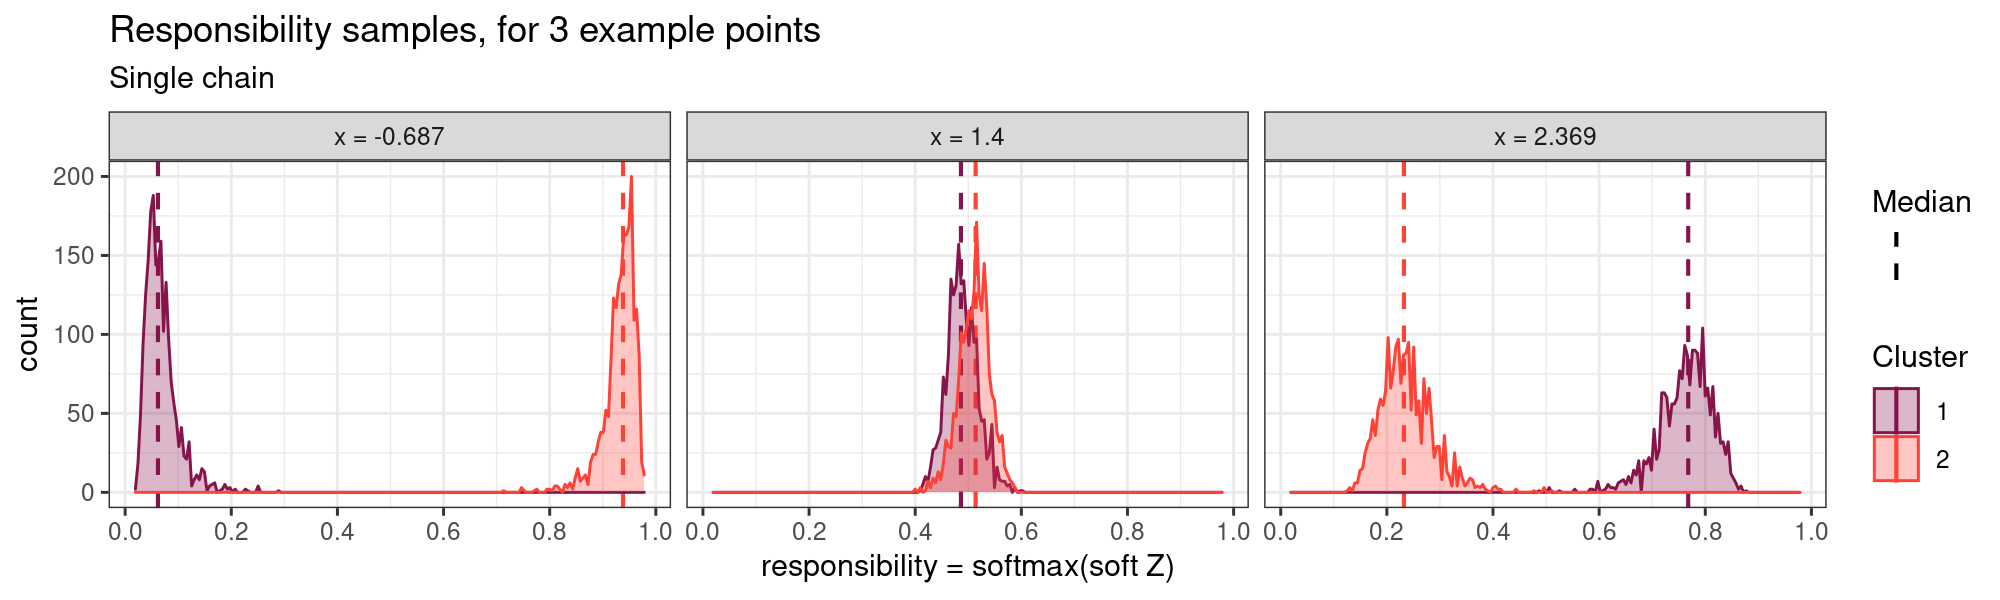

In [23]:
# Plot soft Z samples
options(repr.plot.width=10, repr.plot.height=3, repr.plot.res=200)
ggplot(data_soft_z_point_sc) +
geom_vline(
    data = data_soft_z_point_median_sc,
    aes(xintercept=median_soft_z, linetype=median_legend, color=mu_i),
    size=0.7
) +
geom_area(
    aes(x=soft_z, y=..count.., fill=mu_i, color=mu_i),
    stat="bin", bins=200, alpha=0.3, position="identity"
) +
scale_x_continuous(breaks = seq(-100, 100, by=0.2)) +
scale_color_manual(values=c("#85144b", "#FF4136")) +
scale_fill_manual(values=c("#85144b", "#FF4136")) +
scale_linetype_manual(values=c(2)) +
facet_grid( cols=vars(x_label) ) +
labs(
    title = "Responsibility samples, for 3 example points",
    subtitle = "Single chain",
    fill = "Cluster",
    color = "Cluster",
    x = "responsibility = softmax(soft Z)",
    linetype = "Median"
) + 
theme_bw()
# ggsave("images/soft-z_samples_sc2.png", width=10, height=3)

## Chainsail samples

In [24]:
# Load samples
np = import("numpy")
np$load("chainsail_samples.npy") %>%
{ colnames(.)=c("x", "y"); . } %>%
as_tibble() -> data_samples_chainsail

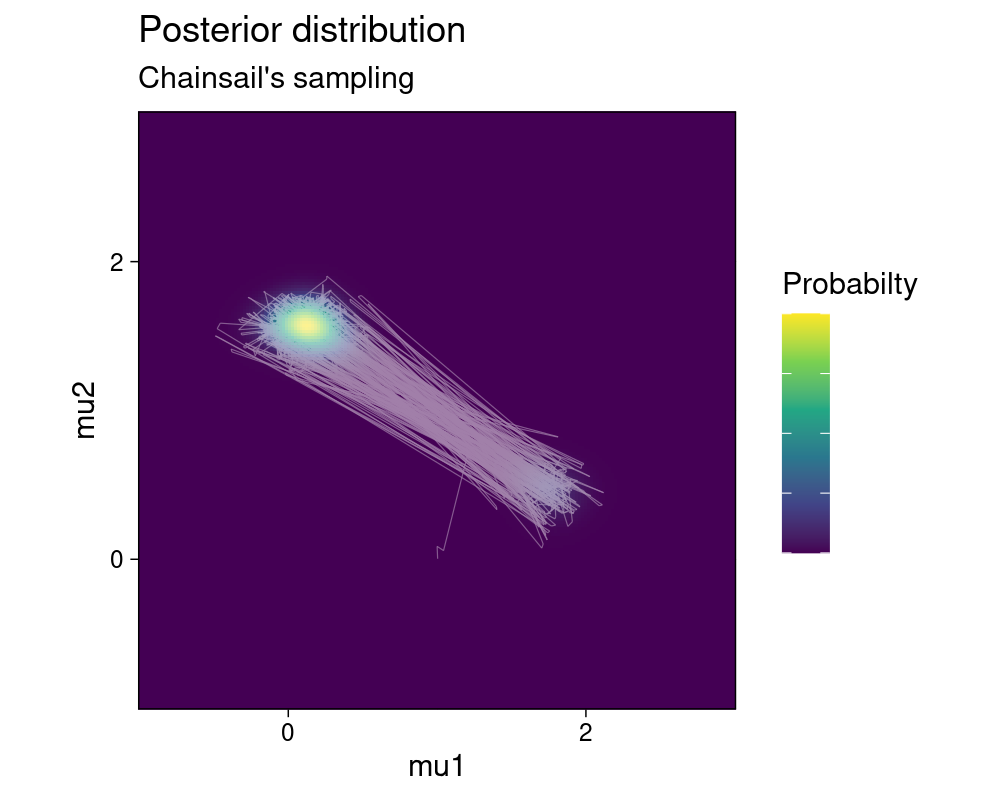

In [25]:
# Plot posterior
options(repr.plot.width=5, repr.plot.height=4, repr.plot.res=200)
ggplot(data_posterior) +
geom_raster(aes(mu1, mu2, fill=prob), alpha=1) +
geom_segment(
    data = data_samples_chainsail,
    aes(x, y, xend=lead(x, default=last(x)), yend=lead(y, default=last(y))),
    color="white", size=0.2, alpha=0.7
) +
geom_raster(aes(mu1, mu2, fill=prob), alpha=0.5) +
labs(
    title = "Posterior distribution",
    subtitle = "Chainsail's sampling",
    fill = "Probabilty"
) + 
scale_x_continuous(breaks = seq(-100, 100, by=2), expand=c(0,0)) +
scale_y_continuous(breaks = seq(-100, 100, by=2), expand=c(0,0)) +
scale_fill_viridis_c(option = "viridis", trans="identity", oob = scales::squish_infinite) +
coord_fixed() +
theme_linedraw() +
theme(legend.text=element_blank())
# ggsave("images/sampling_chainsail_initstate-1-0.png", width=5, height=4)

### Means

In [26]:
# Compute transformed soft_z
data_samples_chainsail %>%
rename(mu1 = x, mu2 = y) %>%
gather() -> data_samples_chainsail_

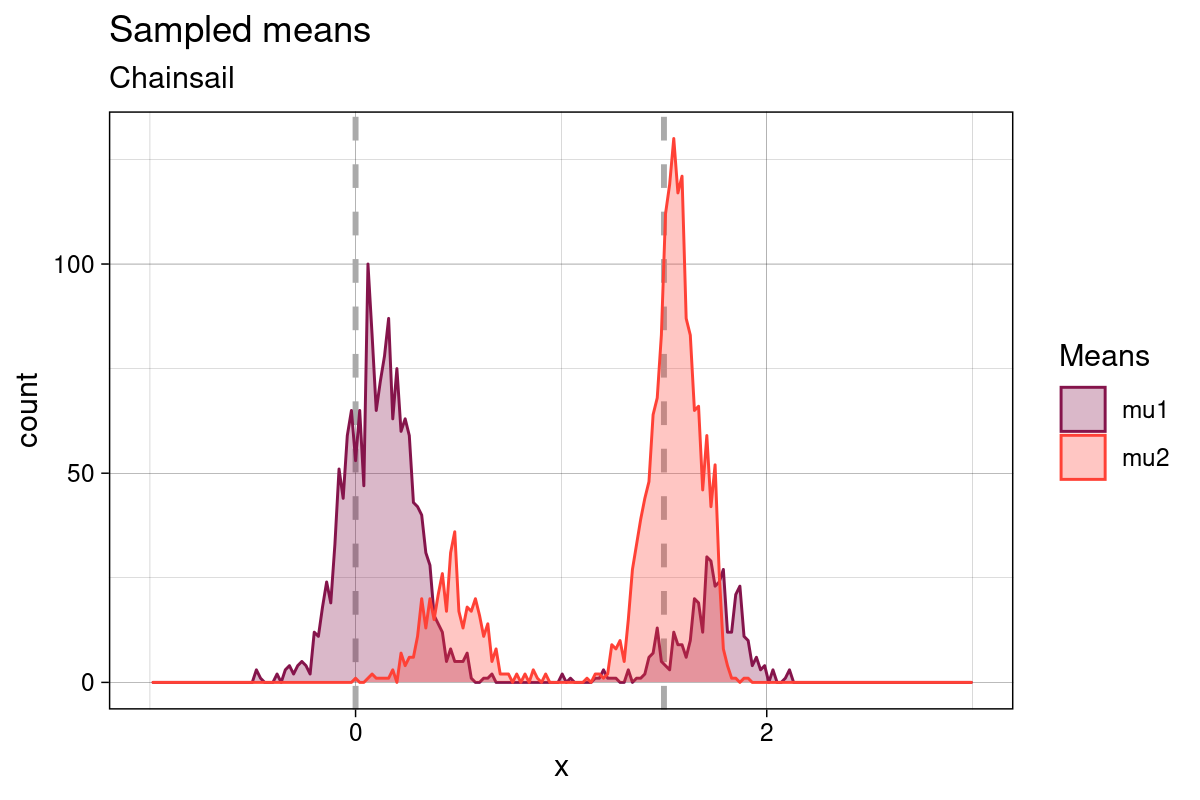

In [27]:
# Plot data points & samples
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
ggplot(data_samples_chainsail_) +
geom_vline(
    data=tibble(x=c(mu1, mu2)),
    aes(xintercept=x),
    size=1, color="#AAAAAA", linetype=2
) +
geom_area(
    data = data_samples_chainsail_,
    aes(value, y=..count.., fill=key, color=key), stat="bin", bins=200, alpha=0.3, position="identity"
) +
scale_fill_manual(values=c("#85144b", "#FF4136")) +
scale_color_manual(values=c("#85144b", "#FF4136")) +
labs(
    title = "Sampled means",
    subtitle = "Chainsail",
    fill = "Means",
    color = "Means",
    x = "x"
) + 
scale_x_continuous(breaks = seq(-100, 100, by=2), limits=c(-1, 3)) +
theme_linedraw()
# ggsave("images/samples_means_chainsail_initstate-1-0.png", width=6, height=4)

### Cluster assignment

In [28]:
# Compute soft_z
n_clusters = 2
weights = c(n_points1/n_total, n_points2/n_total)

data_samples_chainsail %>%
rename(mu1 = x, mu2 = y) %>%
mutate(sample_i = row_number()) %>%
gather(key=mu_i, value=mu, -sample_i) %>%
mutate(mu_i = case_when(mu_i=="mu1" ~ 1, mu_i=="mu2" ~ 2)) %>%
full_join(
    data_points_ %>% mutate(x_i=row_number()),
    by=character()
) %>%
mutate( soft_z = -log(n_clusters) -0.5 * (x - mu)**2 + log(weights[mu_i]) ) -> data_soft_z_chainsail

In [29]:
# Cluster assignment
## Softmax from https://gist.github.com/aufrank/83572
logsumexp <- function (x) {
  y = max(x)
  y + log(sum(exp(x - y)))
}
softmax <- function (x) {
  exp(x - logsumexp(x))
}
## cluster assignements
data_soft_z_chainsail %>%
group_by(mu_i, x_i) %>%
summarise(
    median_soft_z = median(soft_z),
    x = first(x),
    .groups='drop'
) %>%
group_by(x_i) %>%
mutate(prob_cluster = softmax(median_soft_z)) %>%
filter(prob_cluster == max(prob_cluster)) -> data_points_clusterized_chainsail

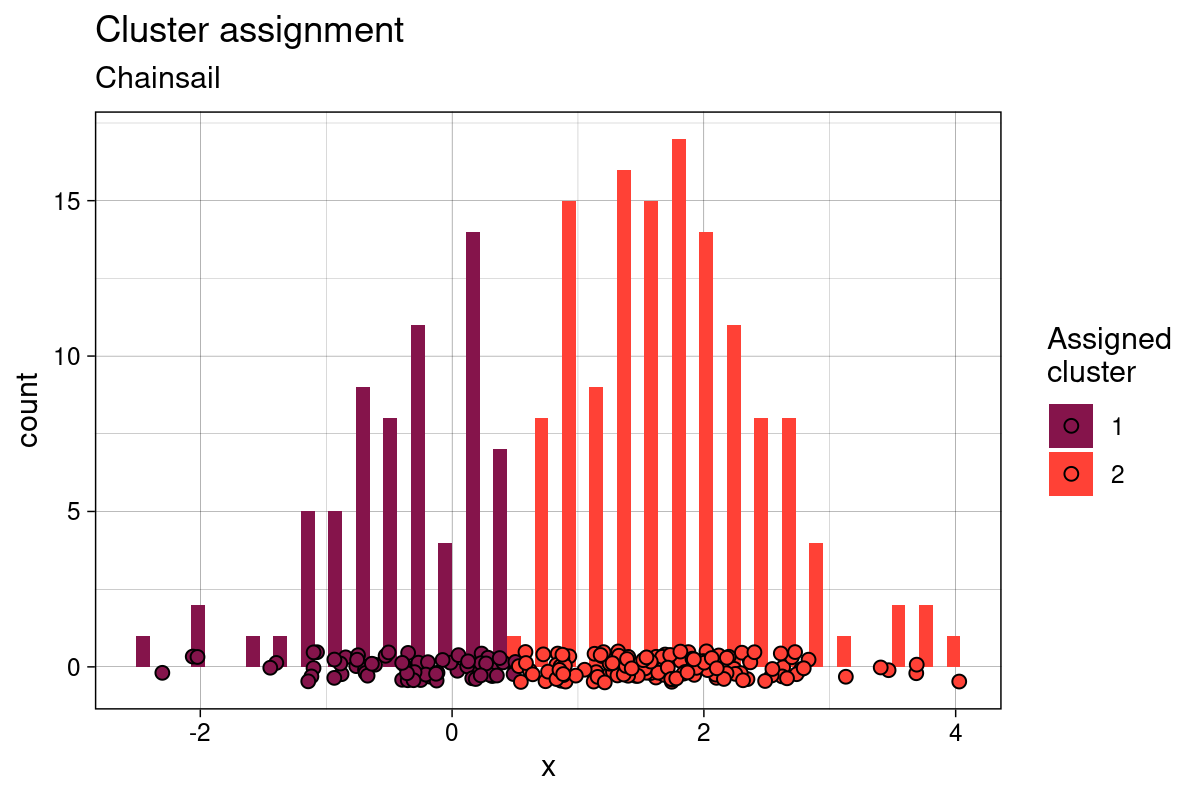

In [30]:
# Plot data points & samples
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
ggplot(data_points_clusterized_chainsail) +
geom_histogram(
    aes(x, fill=as.character(mu_i)), bins=30, alpha=1, position="dodge"
) +
geom_jitter(
    aes(x, 0, fill=as.character(mu_i)), height=0.5, size=2, shape=21
) +
scale_x_continuous(breaks = seq(-100, 100, by=2)) +
scale_fill_manual(values=c("#85144b", "#FF4136")) +
labs(
    title = "Cluster assignment",
    subtitle = "Chainsail",
    fill = "Assigned\ncluster"
) + 
theme_linedraw()
# ggsave("images/cluster_assignment_chainsail_initstate-1-0.png", width=6, height=4)

### Analysis of soft_z

In [31]:
# Select some points in particular
data_soft_z_chainsail %>%
group_by(sample_i, x_i) %>%
arrange(sample_i, x_i) %>%
mutate(soft_z = softmax(soft_z)) %>%
ungroup() %>%
nest( data = c(-x) ) %>%
arrange(x) %>%
slice(c(20, 69, 150)) %>%    # Choose the points
unnest(data) %>%
mutate(
    x_label = "x = " %+% round(x, 3),
    mu_i = as.character(mu_i),
) -> data_soft_z_point_chainsail

# Compute medians
data_soft_z_point_chainsail %>%
group_by(x, mu_i, x_label) %>%
summarise(median_soft_z = median(soft_z), .groups='drop') %>%
mutate(median_legend = "") -> data_soft_z_point_median_chainsail

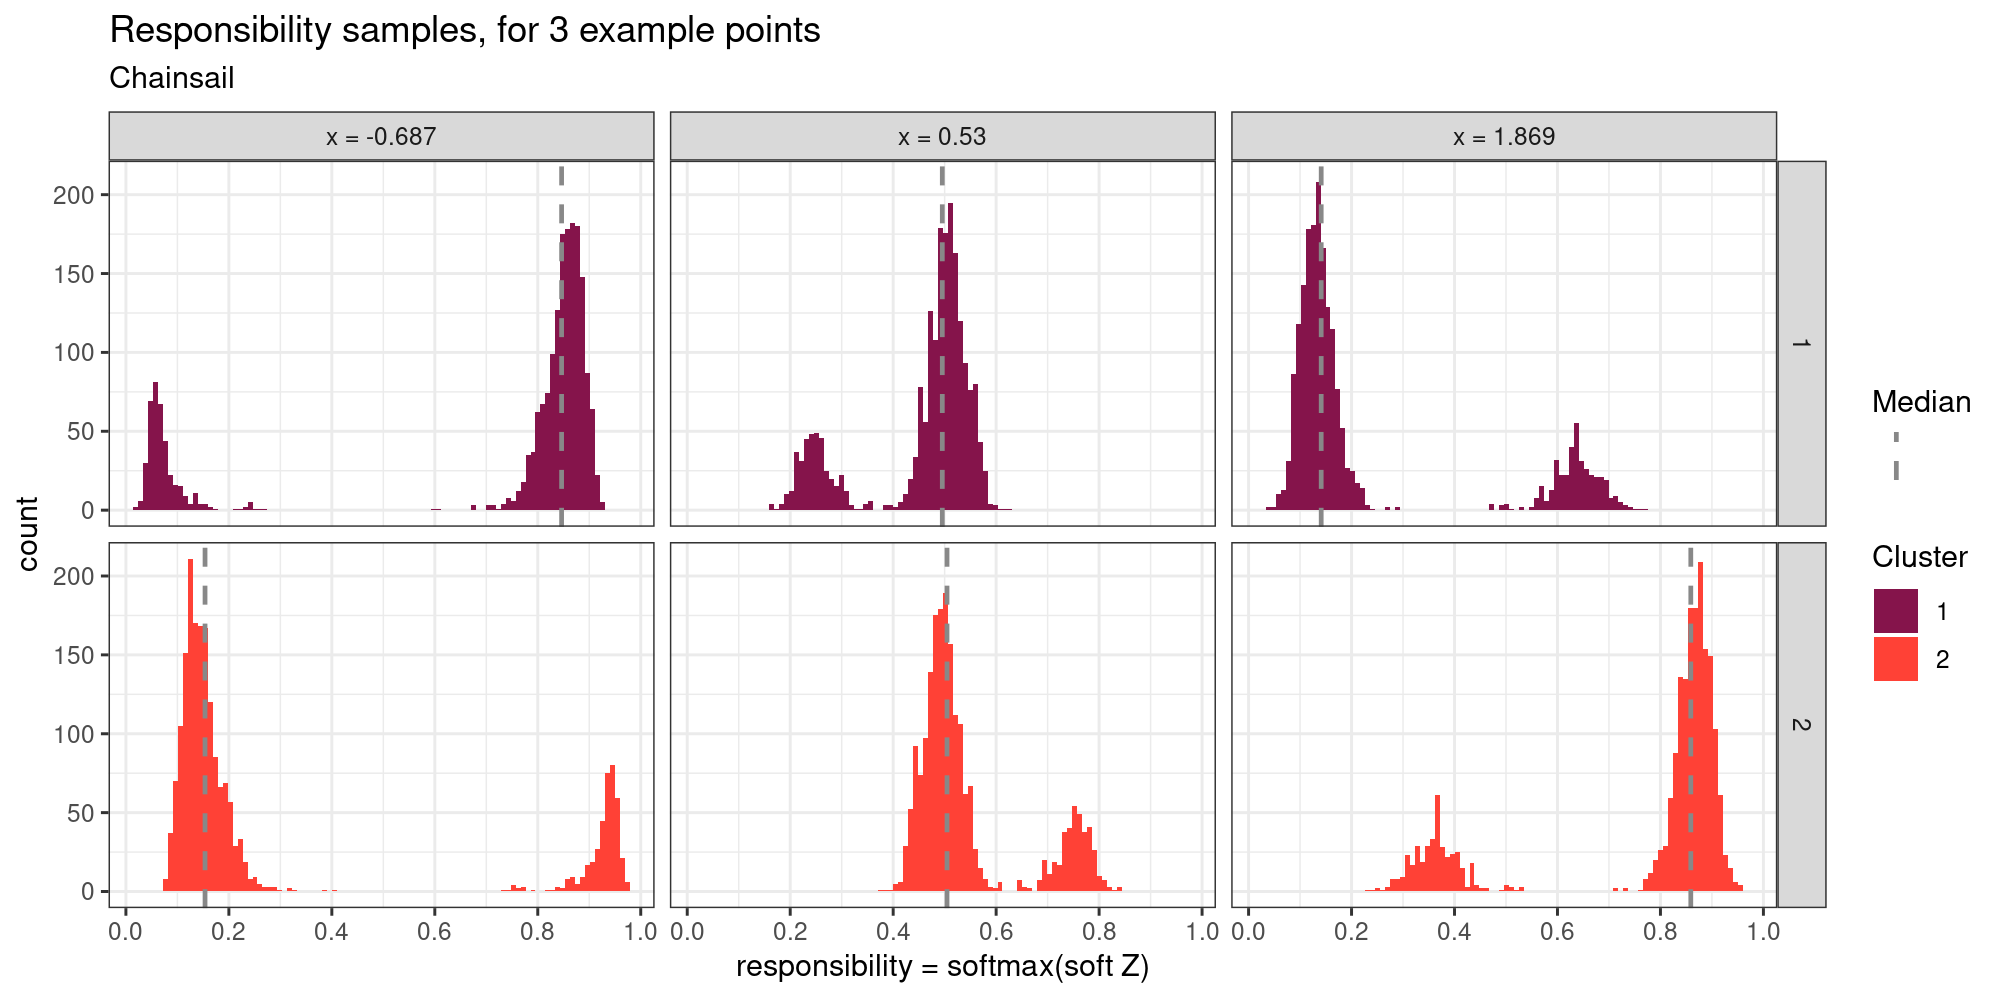

In [33]:
# Plot soft Z samples
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=200)
ggplot(data_soft_z_point_chainsail) +
geom_histogram(
    aes(soft_z, fill=mu_i),
    position="dodge", bins=100
) +
geom_vline(
    data = data_soft_z_point_median_chainsail,
    aes(xintercept=median_soft_z, color=median_legend),
    linetype=2, size=0.8
) +
scale_x_continuous(breaks = seq(-100, 100, by=0.2)) +
scale_color_manual(values=c("#888888")) +
scale_fill_manual(values=c("#85144b", "#FF4136")) +
facet_grid( cols=vars(x_label), rows= vars(mu_i) ) +
labs(
    title = "Responsibility samples, for 3 example points",
    subtitle = "Chainsail",
    fill = "Cluster",
    x = "responsibility = softmax(soft Z)",
    color = "Median"
) + 
theme_bw()
# ggsave("images/soft-z_samples_chainsail.png", width=10, height=5)

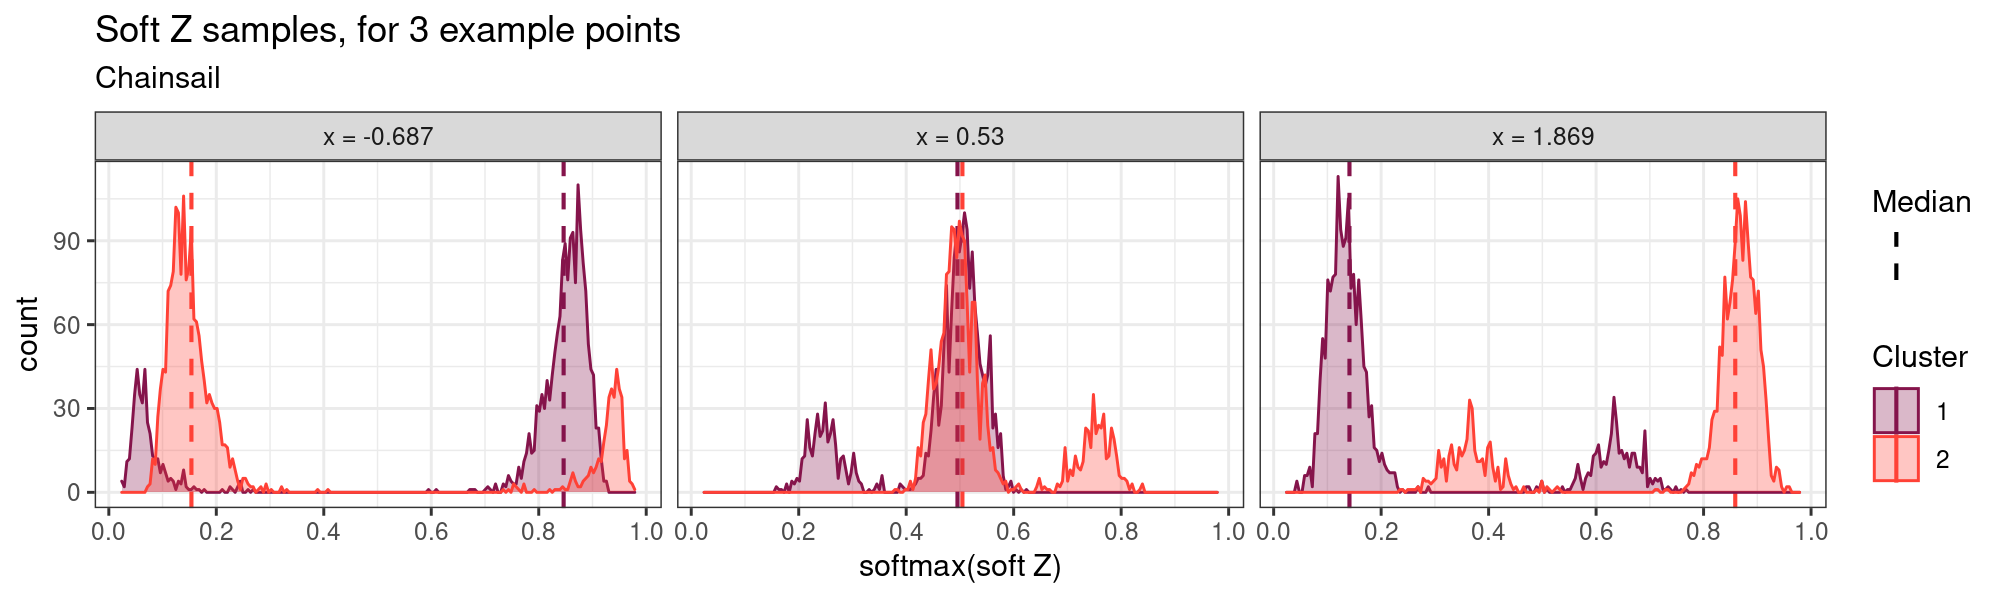

In [33]:
# Plot soft Z samples
options(repr.plot.width=10, repr.plot.height=3, repr.plot.res=200)
ggplot(data_soft_z_point_chainsail) +
geom_vline(
    data = data_soft_z_point_median_chainsail,
    aes(xintercept=median_soft_z, linetype=median_legend, color=mu_i),
    size=0.7
) +
geom_area(
    aes(x=soft_z, y=..count.., fill=mu_i, color=mu_i),
    stat="bin", bins=200, alpha=0.3, position="identity"
) +
scale_x_continuous(breaks = seq(-100, 100, by=0.2)) +
scale_color_manual(values=c("#85144b", "#FF4136")) +
scale_fill_manual(values=c("#85144b", "#FF4136")) +
scale_linetype_manual(values=c(2)) +
facet_grid( cols=vars(x_label) ) +
labs(
    title = "Responsibility samples, for 3 example points",
    subtitle = "Chainsail",
    fill = "Cluster",
    color = "Cluster",
    x = "responsibility = softmax(soft Z)",
    linetype = "Median"
) + 
theme_bw()
ggsave("images/soft-z_samples_chainsail2.png", width=10, height=3)